# Sentiment Analysis with LSTMs using Keras
## Deep Learning (18CSE484T) Group Project

### Group Members:

- Bhavesh Laddagiri (RA1911026030032)
- Akshaj Vishwanathan (RA1911026030003)
- Hardik Gupta (RA1911026030027)

## Requirements
- Tensorflow 2
- HuggingFace Datasets (`pip install datasets`)
- Numpy

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

## Dataset

In [2]:
# Download the imdb movie reviews dataset for binary sentiment analysis
imdb_dataset = load_dataset("imdb")

Reusing dataset imdb (C:\Users\bhave\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_data = imdb_dataset['train'].to_pandas().sample(25000) # shuffle
test_data = imdb_dataset['test'].to_pandas()

In [219]:
# check average number of words in text
np.mean(list(map(lambda x: len(x.split()), train_data['text'])))

233.7872

In [221]:
print(f'Train Data: {len(train_data)}')
print(f'Test Data: {len(test_data)}')

Train Data: 25000
Test Data: 25000


In [249]:
vocab_size = 40000
embedding_dim = 32
maxlen = 150

In [250]:
# Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')

In [251]:
# Fit the tokenizer to the training data
tokenizer.fit_on_texts(train_data['text'])

In [252]:
# Get the vocabulary dictionary
vocab = tokenizer.word_index

In [253]:
def preprocess_text(texts, tokenizer, maxlen):
    '''Preprocess a list of text sequences'''
    # convert string to sequence of integers based on vocab
    sequences = tokenizer.texts_to_sequences(texts)
    
    # pad sequences to fixed length
    padded = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')
    
    return padded

In [254]:
X_train = preprocess_text(train_data['text'], tokenizer, maxlen)
X_test = preprocess_text(test_data['text'], tokenizer, maxlen)

In [229]:
X_train.shape

(25000, 150)

In [230]:
X_test.shape

(25000, 150)

In [231]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [232]:
y_train.shape

(25000,)

In [233]:
y_test.shape

(25000,)

## Build Model

In [234]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [235]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [236]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 32)           1280000   
                                                                 
 lstm_10 (LSTM)              (None, 16)                3136      
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,283,425
Trainable params: 1,283,425
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [237]:
num_epochs = 10
batch_size = 32

In [238]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=num_epochs, 
    validation_data=(X_test, y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3), 
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
    ]
)

Epoch 1/10
782/782 [==============================] - 33s 40ms/step - loss: 0.5019 - accuracy: 0.7421 - val_loss: 0.4201 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - 30s 39ms/step - loss: 0.2547 - accuracy: 0.9014 - val_loss: 0.4142 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 3/10
782/782 [==============================] - 31s 40ms/step - loss: 0.1559 - accuracy: 0.9443 - val_loss: 0.5181 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - 32s 41ms/step - loss: 0.0823 - accuracy: 0.9750 - val_loss: 0.5476 - val_accuracy: 0.8156 - lr: 5.0000e-04
Epoch 5/10
782/782 [==============================] - 32s 41ms/step - loss: 0.0495 - accuracy: 0.9873 - val_loss: 0.6301 - val_accuracy: 0.8205 - lr: 2.5000e-04


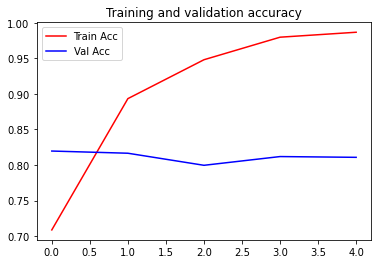

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(len(acc)))

plt.plot(epochs, acc, 'r', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Val Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

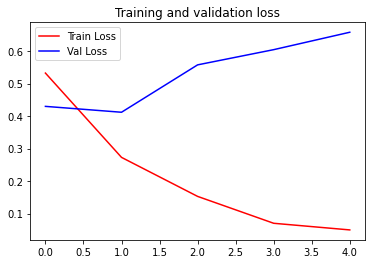

<Figure size 432x288 with 0 Axes>

In [169]:
plt.plot(epochs, loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

In [55]:
# save model
model.save('model.h5')

In [61]:
# save tokenizer
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())

## Inference

In [63]:
# load model and tokenizer
model = keras.models.load_model('model.h5')

with open('tokenizer.json', 'r') as f:
    tokenizer = keras.preprocessing.text.tokenizer_from_json(f.read())

In [4]:
sample_text, label = test_data.iloc[12, :]
sample_text, label

('I first watched this movie back in the mid/late 80\'s, when I was a kid. We couldn\'t even get all the way through it. The dialog, the acting, everything about it was just beyond lame.<br /><br />Here are a few examples... imagine these spoken real dramatically, way over-acted: "Oreegon? You\'re going to Oreegon? Why would anyone want to go to Oreegon?"<br /><br />"Survivalists? Nobody ever told us about any survivalists!"<br /><br />This movie was SO bad, my sister and I rented it again for her 16th birthday party, just so our friends could sit around and laugh at how awful it was. I don\'t think we were able to finish it then either!',
 0)

In [261]:
sample_text = """I have been using CellStrat Workspace for a while now and its bad"""

In [262]:
seq = preprocess_text([sample_text], tokenizer, 150)
seq.shape

(1, 150)

In [263]:
model.predict(seq)

array([[0.14135155]], dtype=float32)